In [151]:
%matplotlib inline

from collections import namedtuple
from contextlib import contextmanager
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import mysql.connector
import numpy as np
import pandas as pd
from pypika import functions as fn
from pypika import MySQLQuery as Query, Table
from pypika.terms import CustomFunction, Function, Term
import re
from scipy.stats import norm
import statsmodels.api as sm

figsize(12.5, 4)

In [152]:
@contextmanager
def managed_cnx():
        cnx = mysql.connector.connect(
            user='root', password='root',
            database='twitter', charset='utf8mb4')
        try:
            yield cnx
        finally:
            cnx.close()

@contextmanager
def managed_cursor(**kwargs):
    with managed_cnx() as cnx:
        cursor = cnx.cursor(**kwargs)
        try:
            yield cursor
        finally:
            cursor.close()

In [153]:
with managed_cursor() as cursor:
    cursor.execute(str(Query.from_('tweets').select(fn.Count('*'))))
    print(cursor.fetchone())

(559272,)


In [154]:
UnixTimestamp = CustomFunction('unix_timestamp', ['date'])
FromUnixtime = CustomFunction('from_unixtime', ['unixtime'])
ConvertTz = CustomFunction('convert_tz', ['dt', 'from_tz', 'to_tz'])

In [155]:
tweets, users = Table('tweets'), Table('users')

In [156]:
KeywordTrajectory = namedtuple('KeywordTrajectory', ['created_at', 'count'])

# TODO: keyword による絞り込み
def keyword_trajectory(cursor, truncated_by='10 minutes'):
    minutes = re.sub(r'^(\d+)\s+minutes$', r'\1', truncated_by)
    assert(minutes.isdecimal())
    seconds = 60 * int(minutes)

    created_at_alias = 'truncated_by_{}min'.format(minutes)
    created_at = ConvertTz(FromUnixtime(fn.Floor(
            UnixTimestamp(tweets.created_at) / seconds) * seconds),
            'GMT', 'Asia/Tokyo')

    s = Query.from_(tweets) \
    .select(
        created_at.as_(created_at_alias),
        fn.Count(tweets.id)) \
    .groupby(created_at_alias)
    
    print('SQL: {}'.format(s))
    cursor.execute(str(s))

    return [KeywordTrajectory._make(r) for r in cursor]

In [157]:
with managed_cursor(buffered=True) as cursor:
    df = pd.DataFrame(data=keyword_trajectory(cursor, truncated_by='10 minutes'))
    df = df.set_index('created_at')
    print(df.head())
    print(df.tail())

SQL: SELECT convert_tz(from_unixtime(FLOOR(unix_timestamp(`created_at`)/600)*600),'GMT','Asia/Tokyo') `truncated_by_10min`,COUNT(`id`) FROM `tweets` GROUP BY `truncated_by_10min`
                     count
created_at                
2020-03-28 22:50:00   1138
2020-03-28 23:00:00   1891
2020-03-28 23:10:00   1744
2020-03-28 23:20:00   1614
2020-03-28 23:30:00   1492
                     count
created_at                
2020-03-31 12:40:00   2204
2020-03-31 12:50:00   1990
2020-03-31 13:00:00   1570
2020-03-31 13:10:00    752
2020-04-01 02:20:00    417


In [158]:
since, until = '2020-03-29 00:00:00', '2020-03-30 23:40:00'
df = df.loc[since:until]

「緊急事態宣言」と「ロックダウン」のツイート数の時系列推移

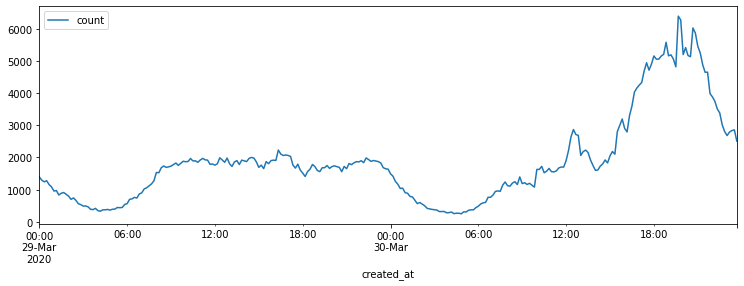

In [159]:
fig, ax = plt.subplots()
df.plot(kind='line', ax=ax)

ローカル線形ドレンドモデルによるモデル化をしてみる。

In [45]:
"""
Univariate Local Linear Trend Model
"""
class LocalLinearTrend(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Model order
        k_states = k_posdef = 2

        # Initialize the statespace
        super(LocalLinearTrend, self).__init__(
            endog, k_states=k_states, k_posdef=k_posdef,
            initialization='approximate_diffuse',
            loglikelihood_burn=k_states
        )

        # Initialize the matrices
        self.ssm['design'] = np.array([1, 0])
        self.ssm['transition'] = np.array([[1, 1],
                                       [0, 1]])
        self.ssm['selection'] = np.eye(k_states)

        # Cache some indices
        self._state_cov_idx = ('state_cov',) + np.diag_indices(k_posdef)

    @property
    def param_names(self):
        return ['sigma2.measurement', 'sigma2.level', 'sigma2.trend']

    @property
    def start_params(self):
        return [np.std(self.endog)]*3

    def transform_params(self, unconstrained):
        return unconstrained**2

    def untransform_params(self, constrained):
        return constrained**0.5

    def update(self, params, *args, **kwargs):
        params = super(LocalLinearTrend, self).update(params, *args, **kwargs)
        
        # Observation covariance
        self.ssm['obs_cov',0,0] = params[0]

        # State covariance
        self.ssm[self._state_cov_idx] = params[1:]


In [46]:
# Log transform
df['lc'] = np.log(df['count'])

In [47]:
# Setup the model
mod = LocalLinearTrend(df['lc'])

# Fit it using MLE (recall that we are fitting the three variance parameters)
res = mod.fit(disp=False)
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                     lc   No. Observations:                  227
Model:               LocalLinearTrend   Log Likelihood                 235.742
Date:                Thu, 02 Apr 2020   AIC                           -465.484
Time:                        21:09:02   BIC                           -455.235
Sample:                    03-29-2020   HQIC                          -461.347
                         - 03-30-2020                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
sigma2.measurement     0.0010      0.001      1.827      0.068   -6.94e-05       0.002
sigma2.level           0.0042      0.001      4.036      0.000       0.002       0.006
sigma2.trend        

/home/p-baleine/.local/share/virtualenvs/fabrication_of_state_of_emergency_20200330-PMno-HTX/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


In [48]:
predict = res.get_prediction()

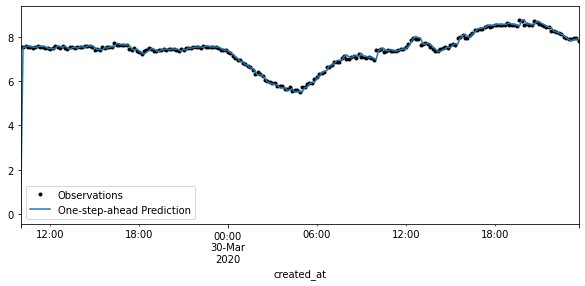

In [49]:
fig, ax = plt.subplots(figsize=(10,4))

# Plot the results
df['lc'].plot(ax=ax, style='k.', label='Observations')
predict.predicted_mean.plot(ax=ax, label='One-step-ahead Prediction')
predict_ci = predict.conf_int(alpha=0.05)
predict_index = np.arange(len(predict_ci))
ax.fill_between(predict_index[2:], predict_ci.iloc[2:, 0], predict_ci.iloc[2:, 1], alpha=0.1)

legend = ax.legend(loc='lower left')

In [131]:
trend = pd.DataFrame(
    { 'value': res.smoothed_state[1] },
    index=df.index)
trend['signals'] = (trend['value'].diff() > 0.0).astype(np.int32).diff().fillna(0.0)
trend.loc[:, 'signals'] = trend['signals'].shift(-1)

(<Figure size 900x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f98c1f24af0>)

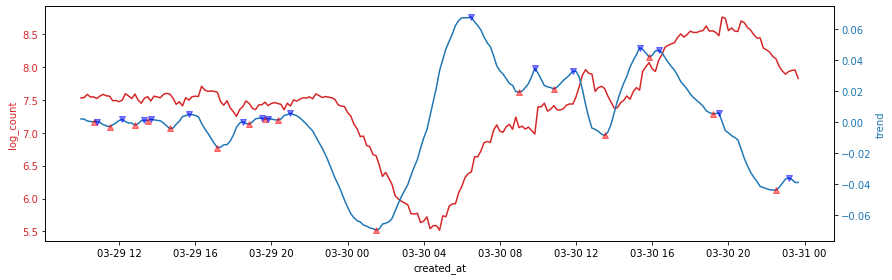

In [137]:
def plot_log_count_and_trend(df, trend):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('created_at')
    ax1.set_ylabel('log_count', color=color)
    ax1.plot(df.index, df['lc'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()

    color = 'tab:blue'
    ax2.set_ylabel('trend', color=color)
    ax2.plot(trend['value'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    ax2.plot(trend['value'].loc[trend['signals'] == 1.0],
        '^', markersize=6, color='r', alpha=0.5)

    ax2.plot(trend['value'].loc[trend['signals'] == -1.0],
        'v', markersize=6, color='b', alpha=0.5)

    fig.tight_layout()
    
    return fig, ax1, ax2
    
search_df = df
plot_log_count_and_trend(search_df, trend)

In [19]:
df['trend'] = trend
df.to_csv('data/search.csv')

A Field Guide to "Fake News"より、

```
While online and platform metrics often serve to take measure of engagement by
means of what Theodore Porter calls “thin descriptions”[11] – i.e. aggregated
quantities such as total likes, shares, posts – we suggest different ways of
exploring how different publics engage with and ascribe meaning to fake news and
how this moves and mobilises different actors in the process.
```

試しに、retweet 数で足切りした上で、時系列にその tweet を並べてみたい。
まず、retweet 数の分布をしりたい

In [20]:
Tweet = namedtuple('Tweet', ['id', 'retweet_count', 'created_at', 'url', 'screen_name', 'text'])

def list_tweets(cursor):
    created_at = ConvertTz(tweets.created_at, 'GMT', 'Asia/Tokyo')

    s = Query.from_(tweets) \
    .join(users) \
    .on(tweets.tweeted_by == users.id) \
    .select(
        tweets.id,
        tweets.retweet_count,
        ConvertTz(tweets.created_at, 'GMT', 'Asia/Tokyo'),
        tweets.text,
        users.screen_name,
        fn.Concat('https://twitter.com/', users.screen_name, '/status/', tweets.id).as_('url'),
    ) \
    .where(Term.isnull(tweets.retweeted_status))

    print('SQL: {}'.format(s))
    cursor.execute(str(s))
    
    return [Tweet._make(r) for r in cursor]

In [21]:
with managed_cursor(buffered=True) as cursor:
    data = list_tweets(cursor)
    df = pd.DataFrame(data=data)
    df = df.set_index('created_at')
    print(df.head())

SQL: SELECT `tweets`.`id`,`tweets`.`retweet_count`,convert_tz(`tweets`.`created_at`,'GMT','Asia/Tokyo'),`tweets`.`text`,`users`.`screen_name`,CONCAT('https://twitter.com/',`users`.`screen_name`,'/status/',`tweets`.`id`) `url` FROM `tweets` JOIN `users` ON `tweets`.`tweeted_by`=`users`.`id` WHERE `tweets`.`retweeted_status` IS NULL
                                      id  retweet_count  \
created_at                                                
2020-03-30 15:02:40  1244505303946629120              0   
2020-03-30 16:28:52  1244526993904766976              1   
2020-03-30 16:30:31  1244527409677778944              0   
2020-03-30 16:10:00  1244522245180895234              0   
2020-03-30 21:22:45  1244600954080473089              0   

                                                                   url  \
created_at                                                               
2020-03-30 15:02:40  「緊急事態宣言」「オーバーシュート」「ロックダウン」\n用語の名称なんてクソどうでもええんだ...   
2020-03-30 16:28:52  「緊急事態宣言を出し

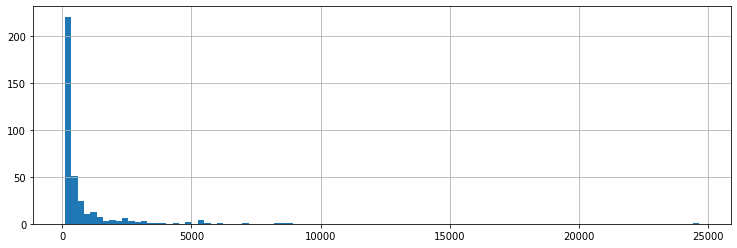

In [22]:
fig, ax = plt.subplots()
df[(100 < df['retweet_count'])]['retweet_count'].hist(ax=ax, bins=100)

In [23]:
df.count()

id               110319
retweet_count    110319
url              110319
screen_name      110319
text             110319
dtype: int64

In [24]:
df[df['retweet_count'] > 1_000].count()

id               66
retweet_count    66
url              66
screen_name      66
text             66
dtype: int64

In [25]:
df[df['retweet_count'] > 1_000]

,id,retweet_count,url,screen_name,text
created_at,,,,,
2020-03-29 16:26:43,1244164065653452800,1093,パリの街角をカモが悠々とお散歩、都市封鎖で人影なく https://t.co/pSonydK7ke,afpbbcom,https://twitter.com/afpbbcom/status/1244164065...
2020-03-31 12:19:31,1244826633292460032,2451,都市封鎖されているウェールズの街に山羊たちが降りてきた！ https://t.co/aPV3...,akasakapatricia,https://twitter.com/akasakapatricia/status/124...
2020-03-30 21:29:45,1244602713708433415,1222,日刊ゲンダイ記者さんの「夜間外出自粛を要請しておきながらこの時間に緊急会見って。ロック...,akomugi,https://twitter.com/akomugi/status/12446027137...
2020-03-30 21:00:13,1244595282920251392,2330,新型コロナの感染拡大を受け、「4月1日にロックダウン決定」という情報が拡散しています。\...,BFJNews,https://twitter.com/BFJNews/status/12445952829...
2020-03-29 23:35:59,1244272095254548481,1389,アジアと欧米でスピードが段違いで、日本や韓国がダイヤモンドプリンセスだー大邱だーって言う割に...,C4Dbeginner,https://twitter.com/C4Dbeginner/status/1244272...
...,...,...,...,...,...
2020-03-30 12:53:46,1244472863509209088,2875,ロックダウン（都市封鎖）についてデマが流れています。正確な情報に留意しデマに流されないで。\...,wadamasamune,https://twitter.com/wadamasamune/status/124447...
2020-03-29 16:24:16,1244163450160304128,2390,【外出制限 欧州でDVが深刻化】\nhttps://t.co/9xlntO1P7A\n\nイ...,YahooNewsTopics,https://twitter.com/YahooNewsTopics/status/124...
2020-03-30 15:32:15,1244512745484996609,24642,【日本医師会 緊急事態宣言だして】\nhttps://t.co/pK7JGNBPgc\n\n...,YahooNewsTopics,https://twitter.com/YahooNewsTopics/status/124...


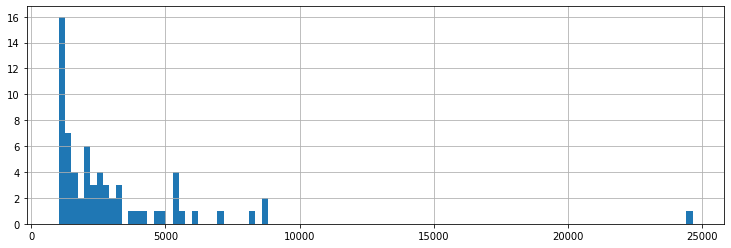

In [26]:
fig, ax = plt.subplots()
df[df['retweet_count'] > 1_000]['retweet_count'].hist(ax=ax, bins=100)

In [27]:
import hashlib

def naive_hash(text):
    return hashlib.sha1(text.encode('utf-8')).hexdigest()

df_gt_1_000_retweets = df[df['retweet_count'] > 1_000]
# df_gt_1_000_retweets.drop('id', axis=1, inplace=True)
#df_gt_1_000_retweets.loc[:, 'screen_name'] = \
#    df_gt_1_000_retweets.loc[:, 'screen_name'].map(naive_hash)

In [28]:
df_gt_1_000_retweets.to_csv('data/over_1_000_retweets.csv')

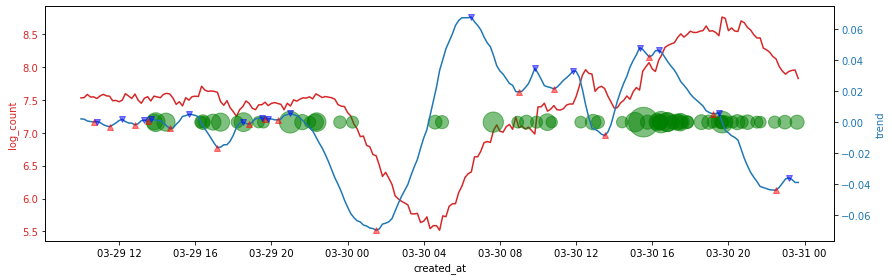

In [150]:
_,  _, ax2 = plot_log_count_and_trend(search_df, trend)

trimed = df_gt_1_000_retweets[since:until]

ax2.scatter(trimed.index, trimed['retweet_count'] * 0,
            s=2 * 4 ** np.log10(trimed['retweet_count']),
           c='g', alpha=.5)